In [18]:
import pandas as pd

In [19]:
df_head = pd.read_csv("twitter.csv")
print(df_head.head())
print(df_head.dtypes)

   longitude   latitude       timestamp  timezone
0 -87.895450  43.063007  20130112000000         2
1 -93.674799  45.025114  20130112000000         2
2 -97.104568  32.709685  20130112000000         2
3 -71.120095  42.351453  20130112000000         1
4 -79.048690  43.100826  20130112000000         1
longitude    float64
latitude     float64
timestamp      int64
timezone       int64
dtype: object


In [20]:
import numpy as np
from pyproj import Transformer

# Select and clean coordinates. Drop any rows that have no longitude or lattitude values. 
df = df_head.copy()
df = df.dropna(subset=["longitude", "latitude"])

# Only keeping data within US
df = df[(df["latitude"].between(24, 50)) & (df["longitude"].between(-126, -66))]
print("Rows after cleaning:", len(df))

Rows after cleaning: 14262517


EPSG: 4326 is the normal lattitude/longitude. EPSG:5070 expresses positions in meters on a flat plane. This transformer converts degrees to meters. Now each (x,y) pair can be clustered meaningfully using Eucledian distance. 

In [21]:
# Convert longitude and lattitude values to metres
transformer = Transformer.from_crs("EPSG:4326", "EPSG:5070", always_xy=True)
x, y = transformer.transform(df["longitude"].values, df["latitude"].values)
X_xy = np.column_stack([x, y])   
print("Example transformed coordinates (in meters)")
print(X_xy[:5])

Example transformed coordinates (in meters)
[[ 655801.4881658  2257721.37181145]
 [ 183007.1126822  2450754.22291679]
 [-102954.36943382 1071499.78290927]
 [2013301.94093267 2415277.55082288]
 [1365304.53938711 2356055.18341978]]


In [22]:
# Run K-means and K-means ++ experiments
import time
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# We'll try a few K values and compare random vs k-means++ initializations.
Ks = [4, 6, 8, 10, 12, 16, 20]
results = []

print("Running K-Means experiments on current dataset...")
for k in tqdm(Ks, desc="K values"):
    for init in ["random", "k-means++"]:
        print(f"Running K={k}, init={init}...")
        t0 = time.time()
        km = KMeans(n_clusters=k, init=init, n_init=10, random_state=42)
        labels = km.fit_predict(X_xy)
        runtime = time.time() - t0
        inertia = km.inertia_

        # silhouette on 50000 rows 
        idx = np.random.choice(len(X_xy), size=min(50000, len(X_xy)), replace=False)
        sil = silhouette_score(X_xy[idx], labels[idx])

        results.append((k, init, inertia, sil, runtime, km.n_iter_))
        print(f"Done: inertia={inertia:.2e}, silhouette={sil:.3f}, time={runtime:.1f}s, iter={km.n_iter_}")

print("\n=== Summary ===")
print("k, init, inertia, silhouette, runtime(s), iterations")
for r in results:
    print(r)

Running K-Means experiments on current dataset...


K values:   0%|                                                                 | 0/7 [00:00<?, ?it/s]

Running K=4, init=random...
Done: inertia=4.22e+18, silhouette=0.454, time=3.7s, iter=13
Running K=4, init=k-means++...


K values:  14%|████████▏                                                | 1/7 [00:39<03:56, 39.47s/it]

Done: inertia=4.22e+18, silhouette=0.456, time=8.7s, iter=9
Running K=6, init=random...
Done: inertia=2.37e+18, silhouette=0.492, time=4.5s, iter=4
Running K=6, init=k-means++...


K values:  29%|████████████████▎                                        | 2/7 [01:19<03:19, 39.98s/it]

Done: inertia=2.35e+18, silhouette=0.509, time=12.0s, iter=4
Running K=8, init=random...
Done: inertia=1.73e+18, silhouette=0.464, time=6.7s, iter=10
Running K=8, init=k-means++...


K values:  43%|████████████████████████▍                                | 3/7 [02:07<02:54, 43.52s/it]

Done: inertia=1.63e+18, silhouette=0.514, time=18.3s, iter=5
Running K=10, init=random...
Done: inertia=1.25e+18, silhouette=0.477, time=9.6s, iter=27
Running K=10, init=k-means++...


K values:  57%|████████████████████████████████▌                        | 4/7 [03:02<02:23, 47.85s/it]

Done: inertia=1.23e+18, silhouette=0.480, time=22.8s, iter=25
Running K=12, init=random...
Done: inertia=9.99e+17, silhouette=0.474, time=9.9s, iter=15
Running K=12, init=k-means++...


K values:  71%|████████████████████████████████████████▋                | 5/7 [03:59<01:42, 51.49s/it]

Done: inertia=1.01e+18, silhouette=0.459, time=26.1s, iter=8
Running K=16, init=random...
Done: inertia=6.93e+17, silhouette=0.483, time=10.2s, iter=23
Running K=16, init=k-means++...


K values:  86%|████████████████████████████████████████████████▊        | 6/7 [05:05<00:56, 56.21s/it]

Done: inertia=6.42e+17, silhouette=0.487, time=33.7s, iter=10
Running K=20, init=random...
Done: inertia=5.49e+17, silhouette=0.465, time=10.3s, iter=12
Running K=20, init=k-means++...


K values: 100%|█████████████████████████████████████████████████████████| 7/7 [06:20<00:00, 54.40s/it]

Done: inertia=4.76e+17, silhouette=0.487, time=43.8s, iter=9

=== Summary ===
k, init, inertia, silhouette, runtime(s), iterations
(4, 'random', 4.2193057815199544e+18, 0.45404223177229625, 3.7319202423095703, 13)
(4, 'k-means++', 4.2192283882969196e+18, 0.4560601315238187, 8.743169069290161, 9)
(6, 'random', 2.3722848045854597e+18, 0.49192231843043294, 4.492988109588623, 4)
(6, 'k-means++', 2.3514014907207214e+18, 0.508947912409546, 12.01476001739502, 4)
(8, 'random', 1.7261240039464064e+18, 0.46389664365925176, 6.67121696472168, 10)
(8, 'k-means++', 1.6254102469511089e+18, 0.514224935844267, 18.329640865325928, 5)
(10, 'random', 1.2492834225216128e+18, 0.4769114543009693, 9.632452249526978, 27)
(10, 'k-means++', 1.2315362831549268e+18, 0.47986081620707, 22.79055428504944, 25)
(12, 'random', 9.989768578665676e+17, 0.4743198373305554, 9.923802137374878, 15)
(12, 'k-means++', 1.0052365398789967e+18, 0.45905952687284846, 26.090291023254395, 8)
(16, 'random', 6.931051604606758e+17, 0.4825

Plotting clusters for K=4...


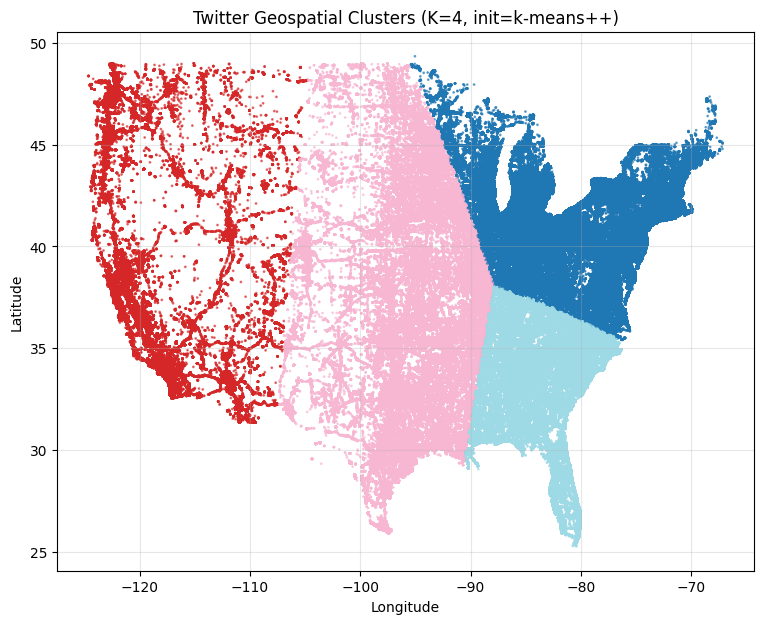

Plotting clusters for K=12...


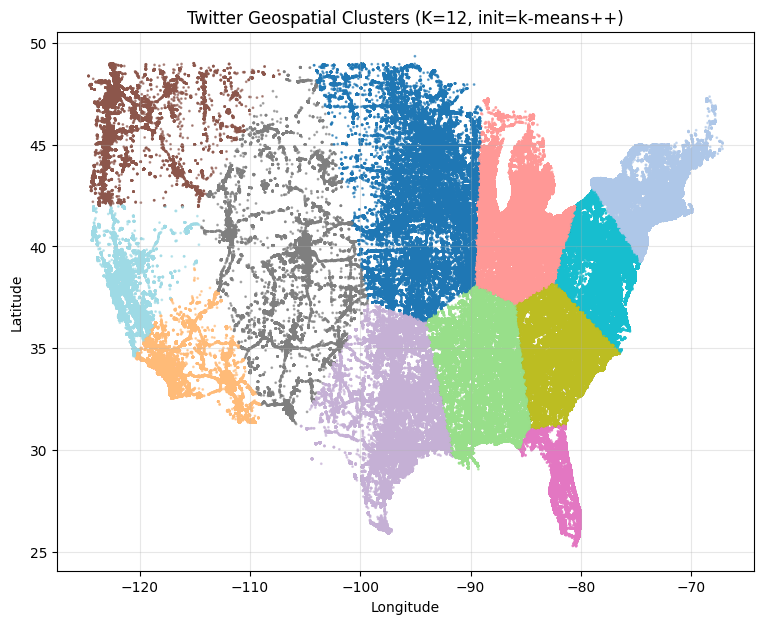

In [23]:
import matplotlib.pyplot as plt

# Pick which K to plot
for best_k in [4, 12]:
    print(f"Plotting clusters for K={best_k}...")

    km = KMeans(n_clusters=best_k, init="k-means++", n_init=10, random_state=42).fit(X_xy)
    labels = km.labels_

    # Convert back to lon/lat for plotting
    to_deg = Transformer.from_crs("EPSG:5070", "EPSG:4326", always_xy=True)
    lon_deg, lat_deg = to_deg.transform(X_xy[:,0], X_xy[:,1])

    plt.figure(figsize=(9,7))
    plt.scatter(lon_deg, lat_deg, s=1, c=labels, cmap="tab20", alpha=0.6)
    plt.title(f"Twitter Geospatial Clusters (K={best_k}, init=k-means++)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True, alpha=0.3)
    plt.show()

,K,Init,Inertia,Silhouette,Runtime,Iterations
1,4,k-means++,4.219228e+18,0.456060,8.743169,9
3,6,k-means++,2.351401e+18,0.508948,12.014760,4
5,8,k-means++,1.625410e+18,0.514225,18.329641,5
7,10,k-means++,1.231536e+18,0.479861,22.790554,25
9,12,k-means++,1.005237e+18,0.459060,26.090291,8
11,16,k-means++,6.421697e+17,0.486694,33.726209,10
13,20,k-means++,4.756301e+17,0.486656,43.795421,9


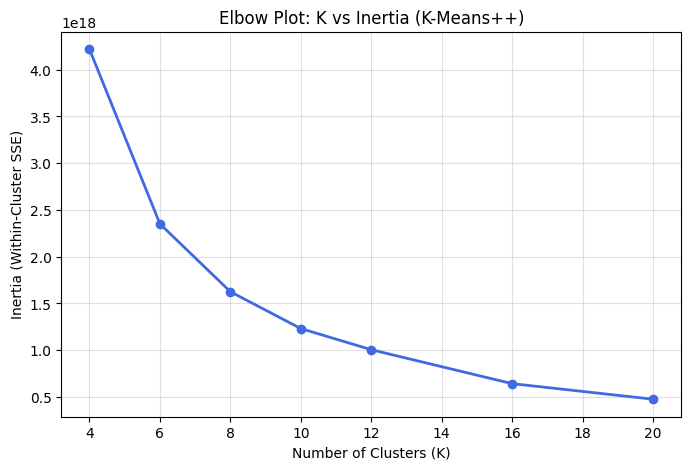

In [24]:
# Convert results (tuples) into a DataFrame
results_df = pd.DataFrame(results, columns=["K", "Init", "Inertia", "Silhouette", "Runtime", "Iterations"])

# Only keep K-Means++ since it performs best
df_pp = results_df[results_df["Init"] == "k-means++"]

display(df_pp)

plt.figure(figsize=(8, 5))
plt.plot(df_pp["K"], df_pp["Inertia"], marker="o", linewidth=2, color="royalblue")
plt.title("Elbow Plot: K vs Inertia (K-Means++)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-Cluster SSE)")
plt.grid(True, alpha=0.4)
plt.show()

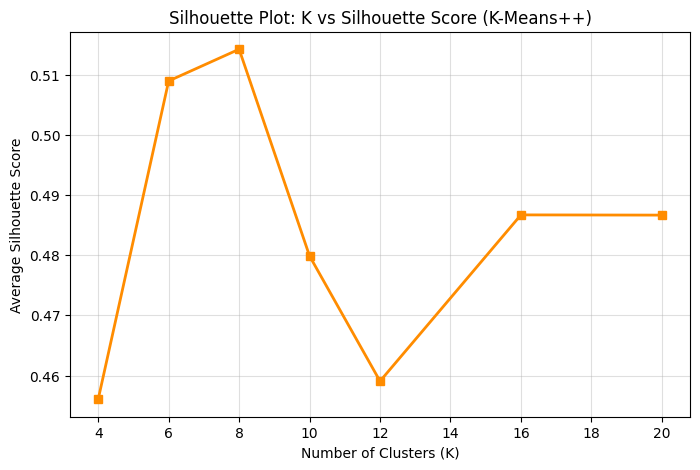

In [25]:
# K vs Silhoutte Score  
plt.figure(figsize=(8, 5))
plt.plot(df_pp["K"], df_pp["Silhouette"], marker="s", linewidth=2, color="darkorange")
plt.title("Silhouette Plot: K vs Silhouette Score (K-Means++)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Average Silhouette Score")
plt.grid(True, alpha=0.4)
plt.show()